# SR Territory Optimization — Pyomo Implementation

This notebook implements the Pfizer Turkey Sales Representative territory optimization model.

The problem consists of assigning geographical units (“bricks”) to Sales Representatives (SRs), each with a fixed or relocatable office. Each brick has a workload index and a distance to every SR office. The goal is to improve the current territory structure by minimizing distance, balancing workload, and limiting disruption from the historical assignment.

We develop the solution in three steps:

**Step 1 — Fixed offices (4 SRs / 22 bricks):**
- Offices remain at their current bricks.
- Only assignments change.
- We study the trade-off between distance and disruption under different workload balance constraints.

**Step 2 — Model extensions:**
- **Scaling** to a 100×10 instance.
- **LP relaxation** to analyze integrality gap.
- **New SR office** with +25% demand using a full 22×22 distance matrix.

**Step 3 — Relocation of offices (facility location):**
- Offices become decision variables.
- We jointly optimize:
  - Total distance,
  - Maximum workload,
  - Number of relocated offices.

All models are formulated in Pyomo and solved with GUROBI.

In [1]:
import pyomo.environ as pyo
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt

# --- Global configuration ---
SOLVER_NAME = "gurobi"  # Project requirement: use GUROBI
solver = pyo.SolverFactory(SOLVER_NAME)

if (solver is None) or (not solver.available()):
    raise RuntimeError(f"Solver '{SOLVER_NAME}' is not available. Install & license it before running this notebook.")

EPSILON_TRICK = 1e-6  # Small positive constant for tie-breaking


## Step 1 — Fixed-Center Territory Optimization

Step 1 focuses on the baseline formulation of the territory optimization problem, where the physical locations of the Sales Representatives’ offices are fixed and cannot be relocated. Under this assumption, the only degrees of freedom lie in the assignment of bricks to SRs. Each brick is characterized by a workload score and its distance to every SR office, and the model aims to redistribute these bricks in a way that improves operational performance while preserving organizational continuity.

The primary objective of Step 1 is to investigate the trade-off between two competing goals: minimizing the total travel distance required to service all bricks, and limiting disruption to the current territorial configuration. Travel distance captures spatial efficiency, whereas disruption reflects the instability introduced when bricks are reassigned away from their historical SR. These competing forces are explored under multiple workload balance constraints, ranging from flexible to restrictive intervals. This allows us to observe how operational efficiency interacts with fairness and business continuity.

By progressively tightening the workload bounds, Step 1 reveals how the feasible solution space contracts and how the Pareto frontier shifts. Loose workload limits allow highly compact territories at the cost of large reassignments, while strict equity requirements preserve the historical allocation structure but prevent substantial improvements in distance. This phase therefore establishes the baseline behaviour of the model, clarifies the impact of core constraints, and lays the conceptual foundation for the larger-scale and structural extensions developed in Step 2 and Step 3.

In [3]:
# --- Data: 4 SRs / 22 Bricks instance ---

# Index values (workload) w_i
W = {
    1: 0.1609, 2: 0.1164, 3: 0.1026, 4: 0.1516, 5: 0.0939, 6: 0.1320, 7: 0.0687, 8: 0.0930,
    9: 0.2116, 10: 0.2529, 11: 0.0868, 12: 0.0828, 13: 0.0975, 14: 0.8177, 15: 0.4115,
    16: 0.3795, 17: 0.0710, 18: 0.0427, 19: 0.1043, 20: 0.0997, 21: 0.1698, 22: 0.2531
}

TOTAL_WORKLOAD = sum(W.values())
M = len(W)      # Number of bricks
N = 4           # Number of SRs (Step 1 & 2.2)

BRICKS = sorted(W.keys())
SRs_FIXED = list(range(1, N + 1))

# Current SR centers and assignments
CENTER_BRICKS = {1: 4, 2: 14, 3: 16, 4: 22}
INITIAL_ASSIGNMENTS = {
    1: {4, 5, 6, 7, 8, 15},
    2: {10, 11, 12, 13, 14},
    3: {9, 16, 17, 18},
    4: {1, 2, 3, 19, 20, 21, 22}
}
INITIAL_OFFICES_INDICES = list(CENTER_BRICKS.values())

# Distance matrix D[i][j]: distance from brick i to office of SR j (Table 3)
D = {
    1: {1: 16.16, 2: 24.08, 3: 24.32, 4: 21.12},
    2: {1: 19.00, 2: 26.47, 3: 27.24, 4: 17.33},
    3: {1: 25.29, 2: 32.49, 3: 33.42, 4: 12.25},
    4: {1: 0.00, 2: 7.93, 3: 8.31, 4: 36.12},
    5: {1: 3.07, 2: 6.44, 3: 7.56, 4: 37.37},
    6: {1: 1.22, 2: 7.51, 3: 8.19, 4: 36.29},
    7: {1: 2.80, 2: 10.31, 3: 10.95, 4: 33.50},
    8: {1: 2.87, 2: 5.07, 3: 5.67, 4: 38.80},
    9: {1: 3.80, 2: 8.01, 3: 7.41, 4: 38.16},
    10: {1: 12.35, 2: 4.52, 3: 4.35, 4: 48.27},
    11: {1: 11.11, 2: 3.48, 3: 2.97, 4: 47.14},
    12: {1: 21.99, 2: 22.02, 3: 24.07, 4: 39.86},
    13: {1: 8.82, 2: 3.30, 3: 5.36, 4: 43.31},
    14: {1: 7.93, 2: 0.00, 3: 2.07, 4: 43.75},
    15: {1: 9.34, 2: 2.25, 3: 1.11, 4: 45.43},
    16: {1: 8.31, 2: 2.07, 3: 0.00, 4: 44.43},
    17: {1: 7.31, 2: 2.44, 3: 1.11, 4: 43.43},
    18: {1: 7.55, 2: 0.75, 3: 1.53, 4: 43.52},
    19: {1: 11.13, 2: 18.41, 3: 19.26, 4: 25.40},
    20: {1: 17.49, 2: 23.44, 3: 24.76, 4: 23.21},
    21: {1: 11.03, 2: 18.93, 3: 19.28, 4: 25.43},
    22: {1: 36.12, 2: 43.75, 3: 44.43, 4: 0.00}
}

print(f"Total workload = {TOTAL_WORKLOAD:.4f} (should be close to 4.0)")


Total workload = 4.0000 (should be close to 4.0)


In [4]:
# ------------------------------------------------------------------
# STEP 1 – Fixed center bricks (4 SRs / 22 bricks)
# ------------------------------------------------------------------

def build_fixed_center_model(W, D, SR_set, L, U, objective_type,
                             epsilon=None,
                             epsilon_trick=EPSILON_TRICK,
                             initial_assignments=None):
    """
    Build the MIP model for the fixed-center problem (Step 1 & 2.1).
    - objective_type: 'distance', 'disruption', or 'epsilon' (epsilon-constraint)
    """
    model = pyo.ConcreteModel()
    bricks = sorted(W.keys())
    model.I = pyo.Set(initialize=bricks)
    model.J = pyo.Set(initialize=SR_set)

    # Variables
    model.x = pyo.Var(model.I, model.J, within=pyo.Binary)

    # Objectives
    Z_Dist = sum(D[i][j] * model.x[i, j] for i in model.I for j in model.J)

    if initial_assignments is None:
        initial_assignments = INITIAL_ASSIGNMENTS

    Z_Disc = sum(
        W[i] * model.x[i, j]
        for j in model.J
        for i in model.I
        if (j in initial_assignments) and (i not in initial_assignments[j])
    )

    # Objective selection
    if objective_type == "distance":
        model.obj = pyo.Objective(expr=Z_Dist, sense=pyo.minimize)
    elif objective_type == "disruption":
        model.obj = pyo.Objective(expr=Z_Disc, sense=pyo.minimize)
    elif objective_type == "epsilon":
        if epsilon is None:
            raise ValueError("epsilon must be provided when objective_type='epsilon'.")
        model.obj = pyo.Objective(expr=Z_Dist + epsilon_trick * Z_Disc, sense=pyo.minimize)
    else:
        raise ValueError("Invalid objective_type. Use 'distance', 'disruption', or 'epsilon'.")

    # Constraints
    # Unique assignment
    def assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.J) == 1
    model.assignment_con = pyo.Constraint(model.I, rule=assignment_rule)

    # Workload balance
    def workload_lower_rule(model, j):
        return sum(W[i] * model.x[i, j] for i in model.I) >= L
    model.workload_low_con = pyo.Constraint(model.J, rule=workload_lower_rule)

    def workload_upper_rule(model, j):
        return sum(W[i] * model.x[i, j] for i in model.I) <= U
    model.workload_up_con = pyo.Constraint(model.J, rule=workload_upper_rule)

    # Epsilon constraint on disruption
    if objective_type == "epsilon":
        model.epsilon_con = pyo.Constraint(expr=Z_Disc <= epsilon)

    return model, Z_Dist, Z_Disc


def find_efficient_frontier(W, D, SR_set, L, U, builder_func):
    """
    Compute the non-dominated (distance, disruption) pairs using
    an epsilon-constraint scheme on disruption.
    """
    results = []

    # 1. Find min and max disruption values
    # Minimize disruption
    model_min_disc, Z_Dist_expr, Z_Disc_expr = builder_func(
        W, D, SR_set, L, U, "disruption"
    )
    res = solver.solve(model_min_disc, tee=False)
    if (res.solver.status != pyo.SolverStatus.ok or
            res.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise RuntimeError("Disruption-minimizing model did not solve optimally.")
    Z_Disc_min = pyo.value(Z_Disc_expr)

    # Minimize distance
    model_min_dist, Z_Dist_expr, Z_Disc_expr = builder_func(
        W, D, SR_set, L, U, "distance"
    )
    res = solver.solve(model_min_dist, tee=False)
    opt_dist = pyo.value(Z_Dist_expr)
    opt_disc = pyo.value(Z_Disc_expr)

    print(f"Optimized distance = {opt_dist:.4f}")
    print(f"Disruption at optimized distance = {opt_disc:.4f}")

    if (res.solver.status != pyo.SolverStatus.ok or
            res.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise RuntimeError("Distance-minimizing model did not solve optimally.")
    Z_Disc_max = pyo.value(Z_Disc_expr)

    print(f"Workload balance [{L:.2f}, {U:.2f}] – disruption range: [{Z_Disc_min:.4f}, {Z_Disc_max:.4f}]")

    # 2. Sweep epsilon over this range
    #epsilon_step = min(w for w in W.values() if w > 0) / 20.0
    #epsilon_values = np.arange(Z_Disc_min, Z_Disc_max + epsilon_step / 2.0, epsilon_step)
    epsilon_values = np.linspace(Z_Disc_min, Z_Disc_max, num=50)
    
    best_dist_found = float("inf")

    for eps in sorted(set(np.round(epsilon_values, 6))):
        model_eps, Z_Dist_expr, Z_Disc_expr = builder_func(
            W, D, SR_set, L, U, "epsilon", epsilon=eps
        )
        res = solver.solve(model_eps, tee=False)
        if (res.solver.status == pyo.SolverStatus.ok and
                res.solver.termination_condition == pyo.TerminationCondition.optimal):
            current_Z_Dist = float(pyo.value(Z_Dist_expr))
            current_Z_Disc = float(pyo.value(Z_Disc_expr))

            # Keep only strictly better distances (for non-dominated frontier)
            if current_Z_Dist < best_dist_found - 1e-6:
                assign = {}
                for i in model_eps.I:
                    for j in model_eps.J:
                        if pyo.value(model_eps.x[i, j]) > 0.5:
                            assign[i] = j
                            break

                results.append({
                    "distance": current_Z_Dist,
                    "disruption": current_Z_Disc,
                    "assignment": assign
                })
                best_dist_found = current_Z_Dist

    # Remove duplicates & sort
    results = sorted(results, key=lambda r: r["distance"])
    return results



=== Scenario [0.80, 1.20] ===
Optimized distance = 154.6000
Disruption at optimized distance = 1.2055
Workload balance [0.80, 1.20] – disruption range: [0.1696, 1.2055]
Efficient (Distance, Disruption) solutions:
Dist = 154.6000, Disc = 1.2055
Dist = 154.6300, Disc = 1.1227
Dist = 155.0400, Disc = 0.9967
Dist = 160.6300, Disc = 0.9625
Dist = 160.7600, Disc = 0.8970
Dist = 163.4200, Disc = 0.8425
Dist = 164.6800, Disc = 0.7958
Dist = 165.9600, Disc = 0.5864
Dist = 166.4700, Disc = 0.4996
Dist = 167.2500, Disc = 0.4569
Dist = 168.1900, Disc = 0.4310
Dist = 168.9600, Disc = 0.3736
Dist = 172.9700, Disc = 0.3572
Dist = 173.9100, Disc = 0.3313
Dist = 174.6800, Disc = 0.2739
Dist = 187.2400, Disc = 0.2529
Dist = 188.1800, Disc = 0.2270
Dist = 188.9500, Disc = 0.1696

=== Scenario [0.85, 1.15] ===
Optimized distance = 160.3200
Disruption at optimized distance = 1.1058
Workload balance [0.85, 1.15] – disruption range: [0.2529, 1.1058]
Efficient (Distance, Disruption) solutions:
Dist = 160.320

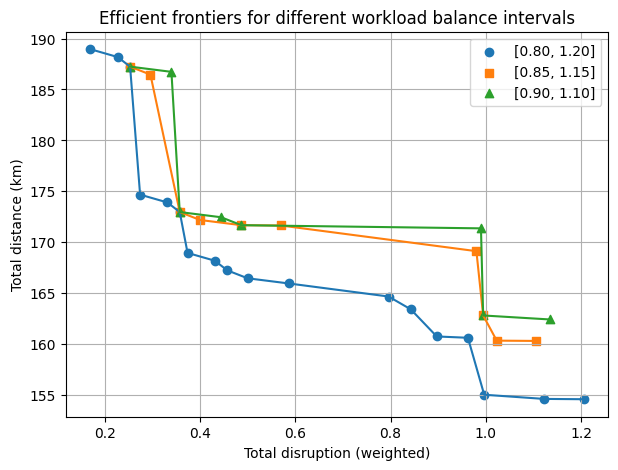

In [5]:
# --- STEP 1: Compute efficient frontiers for three workload intervals ---

scenarios = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]
frontiers = {}

for (L, U) in scenarios:
    print("\n=== Scenario [{:.2f}, {:.2f}] ===".format(L, U))
    eff = find_efficient_frontier(W, D, SRs_FIXED, L, U, builder_func=build_fixed_center_model)
    frontiers[(L, U)] = eff
    print("Efficient (Distance, Disruption) solutions:")
    for sol in eff:
        print(f"Dist = {sol['distance']:.4f}, Disc = {sol['disruption']:.4f}")

# Visualization in objective space
plt.figure(figsize=(7, 5))
markers = ['o', 's', '^']

for (L, U), marker in zip(scenarios, markers):
    pts = frontiers[(L, U)]
    if not pts:
        continue
    xs = [sol["disruption"] for sol in pts]
    ys = [sol["distance"] for sol in pts]
    plt.scatter(xs, ys, marker=marker, label=f"[{L:.2f}, {U:.2f}]")
    plt.plot(xs, ys)


plt.xlabel("Total disruption (weighted)")
plt.ylabel("Total distance (km)")
plt.title("Efficient frontiers for different workload balance intervals")
plt.grid(True)
plt.legend()
plt.show()


The figure illustrates a clear trade-off between territorial disruption and travel efficiency under different workload balance constraints. When workload bounds are relaxed [0.80,1.20], the model can reassign bricks more freely, leading to significantly lower distances and a longer efficient frontier that explores many spatial configurations. As the interval tightens [0.85,1.15] and [0.90,1.10], the frontier shifts upward: stricter fairness constraints reduce the feasible space, limiting the ability to form compact geographic territories and thus increasing total distance. All curves exhibit a “knee” region, where a moderate increase in disruption yields substantial gains in distance; beyond this point, improvements become marginal. At high disruption levels, the three curves converge, reflecting that when workload balancing is no longer binding, the assignment approaches the pure distance-optimal configuration.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def summarize_solution(solution, W, SR_set):
    """
    Affiche pour une solution :
      - les briques attribuées à chaque SR
      - le workload total par SR
      - un boxplot des workloads par SR
    solution : dict avec "assignment" = {brick -> SR}
    W        : dict {brick -> workload}
    SR_set   : liste / set des SR (ex: [1,2,3,4])
    """
    assign = solution["assignment"]

    # Initialisation
    bricks_by_sr = {j: [] for j in SR_set}
    workload_by_sr = {j: 0.0 for j in SR_set}

    # On remplit
    for i, j in assign.items():
        if j in bricks_by_sr:
            bricks_by_sr[j].append(i)
            workload_by_sr[j] += W[i]

    # Affichage texte
    print(f"Distance totale  : {solution['distance']:.4f}")
    print(f"Disruption total : {solution['disruption']:.4f}\n")

    for j in SR_set:
        bricks_list = sorted(bricks_by_sr[j])
        wl = workload_by_sr[j]
        print(f"SR {j}:")
        print(f"  Bricks   = {bricks_list}")
        print(f"  Workload = {wl:.4f}\n")

    # --- Boxplot des workloads ---
    sr_list = sorted(SR_set)
    workloads = [workload_by_sr[j] for j in sr_list]

    x = np.arange(len(sr_list))
    plt.figure(figsize=(5, 4))
    plt.bar(x, workloads)
    plt.xticks(x, [f"SR {j}" for j in sr_list])
    plt.ylabel("Workload")
    plt.title("Workload par SR (barplot)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    # --- Boxplot des workloads ---
    # On transforme en liste de listes : [[wl_SR1], [wl_SR2], ...]
    data = [[w] for w in workloads]
    positions = np.arange(1, len(sr_list) + 1)

    plt.figure(figsize=(5, 4))
    plt.boxplot(data, positions=positions, widths=0.6)
    plt.xticks(positions, [f"SR {j}" for j in sr_list])
    plt.ylabel("Workload")
    plt.title("Workload par SR (boxplot)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


Distance totale  : 154.6300
Disruption total : 1.1227

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 19, 20]
  Workload = 0.9548

SR 2:
  Bricks   = [11, 12, 13, 14, 18]
  Workload = 1.1275

SR 3:
  Bricks   = [10, 15, 16, 17]
  Workload = 1.1149

SR 4:
  Bricks   = [1, 2, 3, 21, 22]
  Workload = 0.8028



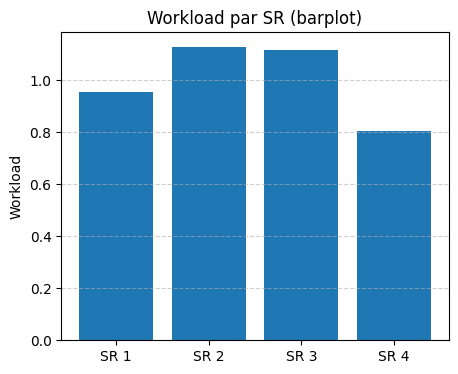

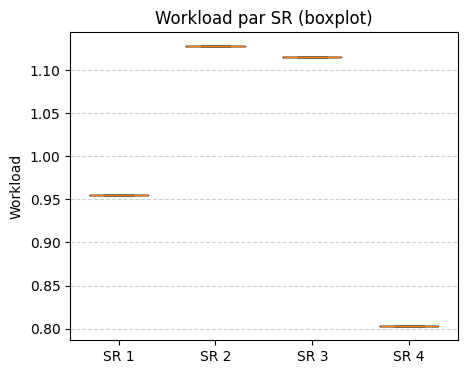

In [9]:
sol = frontiers[(0.8, 1.2)][0]   
summarize_solution(sol, W, SRs_FIXED)

Distance totale  : 160.3200
Disruption total : 1.1058

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12, 19]
  Workload = 0.9379

SR 2:
  Bricks   = [11, 13, 14, 18]
  Workload = 1.0447

SR 3:
  Bricks   = [10, 15, 16, 17]
  Workload = 1.1149

SR 4:
  Bricks   = [1, 2, 3, 20, 21, 22]
  Workload = 0.9025



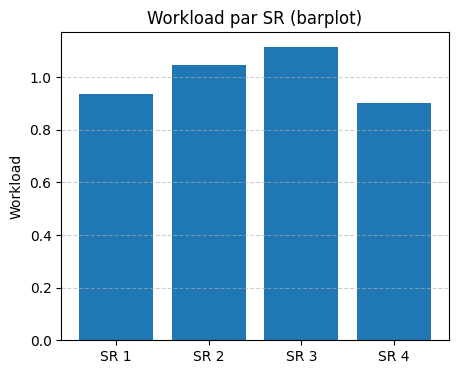

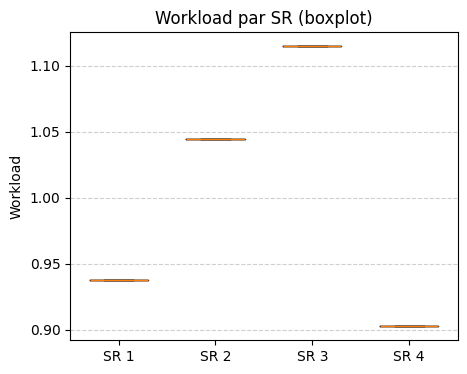

In [7]:
sol = frontiers[(0.85, 1.15)][0]   
summarize_solution(sol, W, SRs_FIXED)

Distance totale  : 162.4300
Disruption total : 1.1341

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12, 19]
  Workload = 0.9379

SR 2:
  Bricks   = [11, 13, 14, 17]
  Workload = 1.0730

SR 3:
  Bricks   = [10, 15, 16, 18]
  Workload = 1.0866

SR 4:
  Bricks   = [1, 2, 3, 20, 21, 22]
  Workload = 0.9025



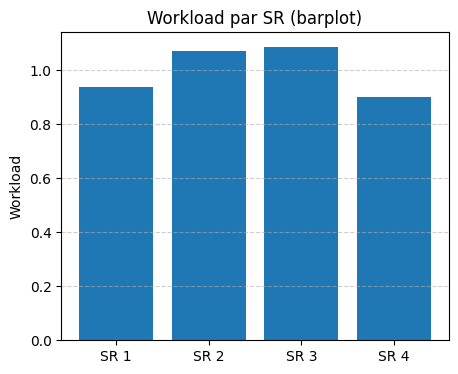

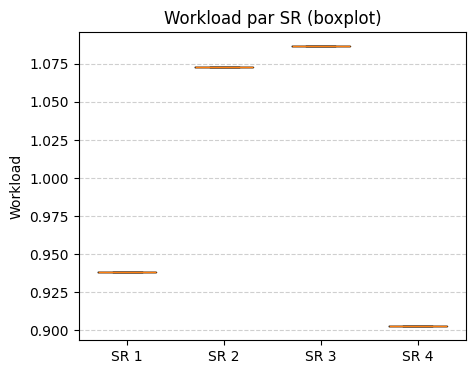

In [8]:
sol = frontiers[(0.9, 1.1)][0]   
summarize_solution(sol, W, SRs_FIXED)

Across the three scenarios, the barplots show that all optimized solutions achieve a globally well-balanced workload distribution among the four Sales Representatives. Although slight differences appear, SR2 and SR3 consistently carry a marginally higher share, while SR4 remains slightly below the others, the disparities never exceed the allowed bounds. As the workload interval tightens, these differences reduce even further, indicating that the model naturally redistributes bricks to approach uniform load when constraints become stricter. Overall, the workload profiles confirm that the optimization maintains fairness while improving territorial efficiency.

In [9]:
def plot_workload_profiles(frontier, W, SR_set, title="Workload per SR along the frontier"):
    """
    Frontier : liste des solutions renvoyées par find_efficient_frontier
    W        : workloads
    SR_set   : liste des SR, ex [1,2,3,4]
    """

    # Préparer les courbes
    workloads = {j: [] for j in SR_set}

    for sol in frontier:
        assign = sol["assignment"]

        # calcul du workload pour chaque SR
        wl = {j: 0.0 for j in SR_set}
        for i, j in assign.items():
            wl[j] += W[i]

        for j in SR_set:
            workloads[j].append(wl[j])

    # Graphique
    plt.figure(figsize=(8,5))

    for j in SR_set:
        plt.plot(workloads[j], marker="o", label=f"SR {j}")

    plt.xlabel("Solution index along frontier (sorted by distance)")
    plt.ylabel("Workload")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


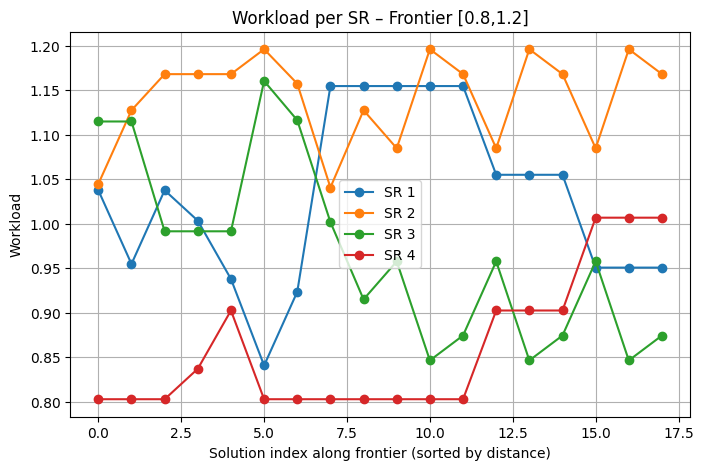

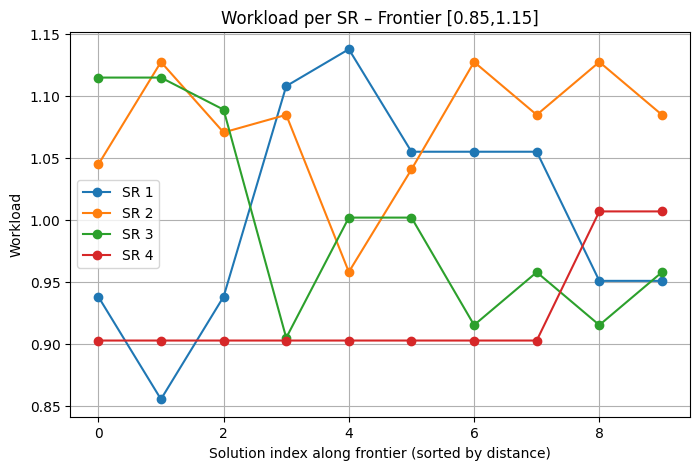

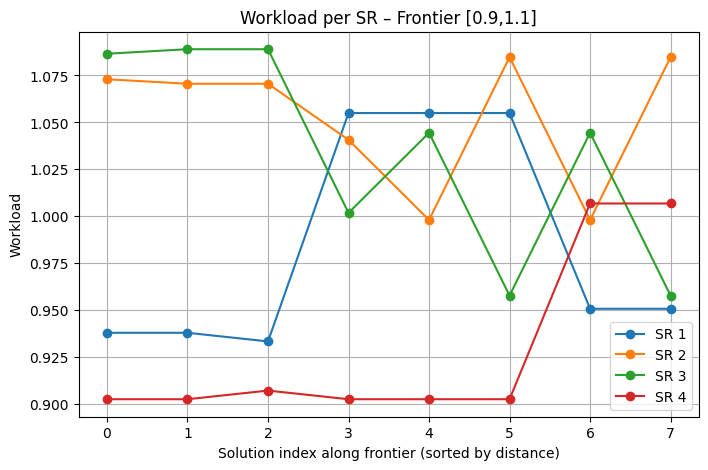

In [10]:
frontier = frontiers[(0.8, 1.2)]
plot_workload_profiles(frontier, W, SRs_FIXED, 
                       title="Workload per SR – Frontier [0.8,1.2]")
frontier = frontiers[(0.85, 1.15)]
plot_workload_profiles(frontier, W, SRs_FIXED, 
                       title="Workload per SR – Frontier [0.85,1.15]")
frontier = frontiers[(0.9, 1.1)]
plot_workload_profiles(frontier, W, SRs_FIXED, 
                       title="Workload per SR – Frontier [0.9,1.1]")

Across the three workload intervals, the workload profiles show a clear tightening effect on feasible allocations as constraints become stricter. Under the wide range [0.80,1.20], the solution space is large, and workloads fluctuate significantly along the frontier, with SR2 and SR3 often absorbing high volumes while SR4 remains near the lower bound. When the interval narrows to [0.85,1.15], fluctuations decrease and the curves become more clustered, preventing extreme imbalances and forcing SRs to share bricks more uniformly. Under the strictest bounds [0.90,1.10], all workloads converge to a narrow band close to the mean, showing that tighter fairness constraints almost entirely dictate feasible assignments and leave very limited flexibility for geographical optimization.

## Step 2 — Scaling and Structural Extensions of the Fixed-Center Model

After establishing the fixed-center formulation and analyzing the trade-off between distance minimization and disruption (Step 1), Step 2 investigates the **robustness, scalability, and structural behaviour** of the model under different conditions. Rather than modifying the core mathematical structure, this step evaluates how the optimization behaves when the problem size increases, the integrality constraints are relaxed, or the underlying demand and infrastructure evolve.

The first extension (Step 2.1) applies the model to a **larger instance of 100 bricks and 10 Sales Representatives**, preserving the fixed office locations. This experiment tests whether the model scales computationally and whether the distance–disruption Pareto frontier remains consistent in shape when the number of decision variables grows by an order of magnitude. Demonstrating similar behaviour would indicate that the fixed-center formulation generalizes well beyond the 22-brick toy case.

The second extension (Step 2.2) relaxes the binary assignment variables into continuous ones, allowing bricks to be fractionally assigned across SRs. Although such solutions are not operationally implementable, the resulting linear program provides a **lower bound** on achievable distances and reveals the **integrality gap** of the problem. Comparing integer and relaxed frontiers helps distinguish limitations due to combinatorial structure from those imposed purely by geometric constraints.

Finally, Step 2.3 considers the impact of a **25% increase in demand**, which logically requires a fifth SR. Instead of arbitrarily selecting its location, each brick is tested as a potential office site using the real 22×22 brick-to-brick distance matrix. This extension bridges the assignment model of Step 1 with the facility-location logic developed in Step 3, offering practical insight into how additional resources should be strategically deployed when market pressure increases.

Overall, Step 2 does not alter the original formulation, but rather evaluates its behaviour under realistic operational scenarios: **bigger instances, relaxed constraints, and structural changes in capacity**. These extensions validate the stability of the model and highlight the circumstances under which more advanced formulations (e.g., relocation models) become necessary.


In [11]:
import pandas as pd

# --- Load 100x10 instance data ---
xl_large = pd.ExcelFile("Pfizer_Project\data\data-100x10.xlsx")
df_large = xl_large.parse("Feuil1")

# La vraie table commence à la ligne 3, avec les bons noms de colonnes
df_large = df_large.iloc[3:].copy()
df_large.columns = ["id", "x", "y", "index", "current", "office"]

# On nettoie
df_large = df_large.dropna(subset=["id"])
df_large["id"] = df_large["id"].astype(int)
df_large["current"] = df_large["current"].astype(float).astype(int)
df_large["office"] = df_large["office"].astype(int)

# Dictionnaire des workloads
LARGE_W = {
    int(row.id): float(row["index"])
    for _, row in df_large.iterrows()
}

# Coordonnées des briques
coords_large = {
    int(row.id): (float(row.x), float(row.y))
    for _, row in df_large.iterrows()
}

# Coordonnées des bureaux (1 office par SR)
office_coords_large = {}
for j in sorted(df_large["current"].unique()):
    cand = df_large[(df_large["current"] == j) & (df_large["office"] == 1)]
    office_coords_large[j] = (float(cand.iloc[0].x), float(cand.iloc[0].y))

# Matrice de distance LARGE_D[i][j] = distance brique i -> bureau du SR j
import math
def euclidean(p, q):
    return float(math.dist(p, q))

LARGE_D = {
    i: {
        j: euclidean(coords_large[i], office_coords_large[j])
        for j in office_coords_large.keys()
    }
    for i in coords_large.keys()
}

# Affectations initiales pour la disruption (current)
INITIAL_ASSIGNMENTS_LARGE = {
    j: set(df_large[df_large["current"] == j]["id"].astype(int).tolist())
    for j in sorted(df_large["current"].unique())
}

print("Total workload (100x10) =", sum(LARGE_W.values()))
print("Number of bricks =", len(LARGE_W))
print("Number of SRs =", len(office_coords_large))

Total workload (100x10) = 9.999999999999998
Number of bricks = 100
Number of SRs = 10


In [12]:
def build_fixed_center_model_large(W, D, SR_set, L, U, objective_type,
                                   epsilon=None,
                                   epsilon_trick=EPSILON_TRICK):
    return build_fixed_center_model(
        W=W,
        D=D,
        SR_set=SR_set,
        L=L,
        U=U,
        objective_type=objective_type,
        epsilon=epsilon,
        epsilon_trick=epsilon_trick,
        initial_assignments=INITIAL_ASSIGNMENTS_LARGE
    )

In [22]:
# ------------------------------------------------------------------
# STEP 2.1 – Scaling check (100 bricks / 10 SRs) — MULTI-SCÉNARIOS
# ------------------------------------------------------------------

RUN_LARGE_INSTANCE = True

if RUN_LARGE_INSTANCE:

    LARGE_M = len(LARGE_W)
    LARGE_N = len(office_coords_large)
    LARGE_SRs = list(range(1, LARGE_N + 1))

    total_workload_large = sum(LARGE_W.values())
    avg_workload_large = total_workload_large / LARGE_N

    # Les trois scénarios comme dans le 4×22
    scenarios_large = [
        (0.8 * avg_workload_large, 1.2 * avg_workload_large),
        (0.85 * avg_workload_large, 1.15 * avg_workload_large),
        (0.9 * avg_workload_large, 1.1 * avg_workload_large),
    ]

    frontiers_large = {}

    print("Solving 100x10 instance for multiple workload scenarios...\n")

    for (L_large, U_large) in scenarios_large:
        print(f"=== Scenario [{L_large:.2f}, {U_large:.2f}] ===")

        res = find_efficient_frontier(
            LARGE_W,
            LARGE_D,
            LARGE_SRs,
            L_large,
            U_large,
            builder_func=build_fixed_center_model_large
        )

        frontiers_large[(L_large, U_large)] = res

        print("Efficient solutions (Distance, Disruption):")
        for sol in res:
            print(f"  Dist = {sol['distance']:.4f}, Disc = {sol['disruption']:.4f}")
        print()

else:
    print("Skipping 100x10 instance.")

Solving 100x10 instance for multiple workload scenarios...

=== Scenario [0.80, 1.20] ===
Optimized distance = 15.0374
Disruption at optimized distance = 2.7746
Workload balance [0.80, 1.20] – disruption range: [0.3427, 2.7746]
Efficient solutions (Distance, Disruption):
  Dist = 15.0374, Disc = 2.7746
  Dist = 15.0401, Disc = 2.7233
  Dist = 15.0417, Disc = 2.6572
  Dist = 15.0536, Disc = 2.5948
  Dist = 15.0540, Disc = 2.5674
  Dist = 15.0566, Disc = 2.5161
  Dist = 15.0824, Disc = 2.4760
  Dist = 15.1007, Disc = 2.3809
  Dist = 15.1010, Disc = 2.3535
  Dist = 15.1096, Disc = 2.3153
  Dist = 15.1109, Disc = 2.2765
  Dist = 15.1209, Disc = 2.2056
  Dist = 15.1213, Disc = 2.1783
  Dist = 15.1268, Disc = 2.1241
  Dist = 15.1602, Disc = 2.0767
  Dist = 15.1699, Disc = 2.0003
  Dist = 15.1702, Disc = 1.9729
  Dist = 15.2036, Disc = 1.9254
  Dist = 15.2372, Disc = 1.8463
  Dist = 15.2375, Disc = 1.8190
  Dist = 15.2819, Disc = 1.7624
  Dist = 15.3211, Disc = 1.7208
  Dist = 15.3301, Disc =

In [29]:
import matplotlib.pyplot as plt

def plot_large_frontiers(frontiers_large, title="Efficient frontiers – 100 bricks / 10 SRs"):
    """
    Trace plusieurs frontières (distance vs disruption) pour le cas 100x10.
    frontiers_large : dict { (L,U) : [solutions] }
                      où chaque solution a 'distance' et 'disruption'.
    """

    if not frontiers_large:
        print("frontiers_large est vide, rien à tracer.")
        return

    plt.figure(figsize=(7, 5))

    markers = ["o", "s", "^", "D", "P"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for idx, ((L, U), frontier) in enumerate(sorted(frontiers_large.items())):
        if not frontier:
            continue

        # on trie les points par disruption pour avoir une courbe propre
        frontier_sorted = sorted(frontier, key=lambda s: s["disruption"])

        xs = [sol["disruption"] for sol in frontier_sorted]
        ys = [sol["distance"]   for sol in frontier_sorted]

        m = markers[idx % len(markers)]
        c = colors[idx % len(colors)]

        plt.scatter(xs, ys, marker=m, color=c)
        plt.plot(xs, ys, linestyle="-", color=c,
                 label=f"[L={L:.2f}, U={U:.2f}]")

    plt.xlabel("Total disruption (weighted)")
    plt.ylabel("Total distance (km)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


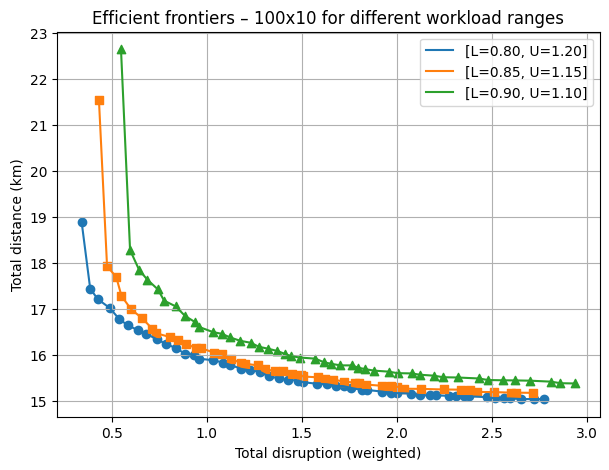

In [30]:
plot_large_frontiers(frontiers_large,
                     title="Efficient frontiers – 100x10 for different workload ranges")

For the 100×10 instance, the Pareto frontiers exhibit the same structural trade-off observed in the smaller case, but with smoother and more continuous behavior due to increased granularity in the solution space. With wide workload bounds [0.80,1.20], the model finds highly distance-efficient configurations, reaching values below 15 km, as it can heavily concentrate workload on spatially central SRs. As the interval tightens [0.85,1.15] and [0.90,1.10], the frontiers shift upward and become less convex, reflecting a reduction of feasible reassignments and the emergence of fairness as a dominant constraint. Interesting patterns appear in the low-disruption region, where strict balancing forces the model into significantly worse solutions without offering meaningful gains in stability. Overall, scaling to 100 bricks amplifies the distance benefits of flexible workload allocation and confirms that equality constraints substantially restrict the attainable efficiency of the system.

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_large_solution(solution, coords_large, office_coords=None, title=None):
    """
    Visualise une solution 100x10 dans le plan :
      - chaque brick colorée selon le SR auquel elle est affectée
      - les centres des SR indiqués en gros symboles si office_coords est donné

    solution      : dict avec
                    - solution["assignment"] = {brick -> SR}
                    - solution["distance"], solution["disruption"]
    coords_large  : dict {brick -> (x, y)}
    office_coords : dict {SR -> (x, y)} optionnel
    """
    assign = solution["assignment"]

    # palette de couleurs pour les SR (10 SR max -> tab10)
    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(6, 6))

    # 1) points : briques colorées par SR
    for i, j in assign.items():
        if i not in coords_large:
            continue
        x, y = coords_large[i]
        color = cmap((j - 1) % 10)
        plt.scatter(x, y, s=25, color=color)
        # petit numéro de brique
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6)

    # 2) centres des SR (si dispo)
    if office_coords is not None:
        for sr, (cx, cy) in office_coords.items():
            plt.scatter(cx, cy,
                        s=120,
                        facecolors="none",
                        edgecolors="black",
                        linewidths=2)
            plt.text(cx, cy, f"SR{sr}",
                     fontsize=8, fontweight="bold",
                     ha="center", va="center")

    if title is None:
        title = f"100x10 – solution (Dist={solution['distance']:.2f}, Disc={solution['disruption']:.2f})"

    plt.title(title)
    plt.xlabel("x-coord")
    plt.ylabel("y-coord")
    plt.grid(True, alpha=0.4)
    plt.axis("equal")
    plt.show()


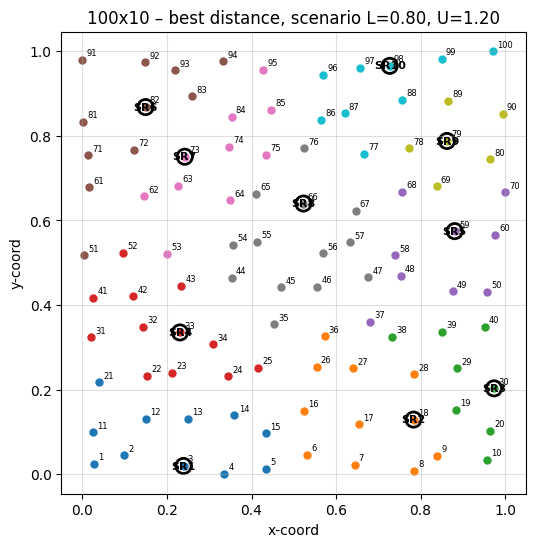

In [32]:
# récupérer le premier scénario dans l'ordre
scenario0 = sorted(frontiers_large.keys())[0]
frontier0 = frontiers_large[scenario0]

# solution la plus faible en distance (normalement index 0 car déjà trié)
best_sol = frontier0[0]

plot_large_solution(best_sol, coords_large, office_coords_large,
                    title=f"100x10 – best distance, scenario L={scenario0[0]:.2f}, U={scenario0[1]:.2f}")


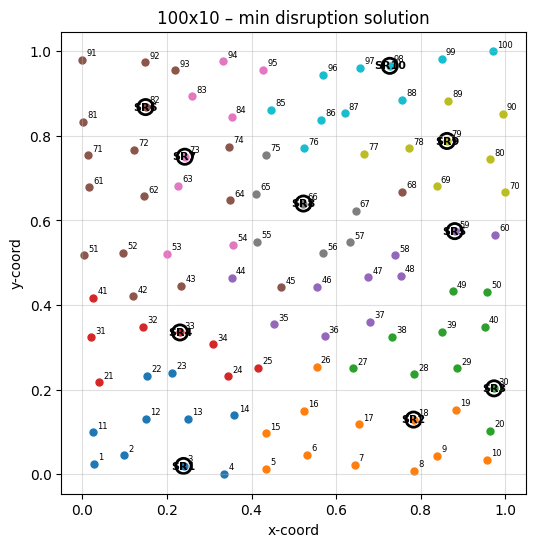

In [33]:
last_sol = frontier0[-1]
plot_large_solution(last_sol, coords_large, office_coords_large,
                    title="100x10 – min disruption solution")

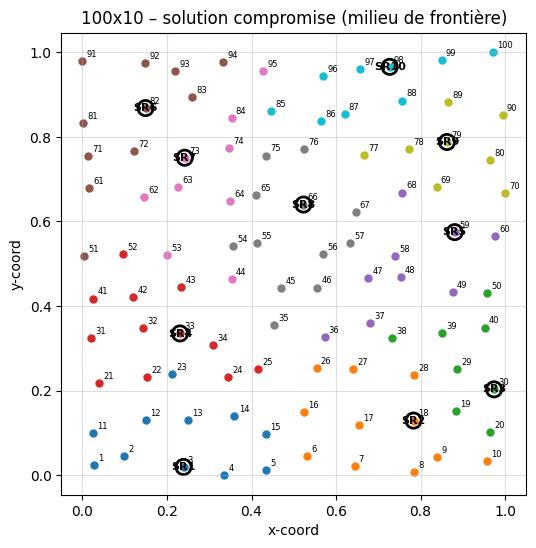

In [34]:
mid_sol = frontier0[len(frontier0)//2]
plot_large_solution(mid_sol, coords_large, office_coords_large,
                    title="100x10 – solution compromise (milieu de frontière)")

Across the three configurations, the spatial structure of territories reveals how the model resolves the tension between efficiency and continuity. In the distance-optimal solution (left), bricks cluster tightly around the nearest SR office, producing highly compact and locally coherent catchment areas; this creates a mosaic of clearly partitioned zones and minimizes travel distance, but at the cost of substantial reassignment from the original allocation. In contrast, the minimum-disruption solution (middle) preserves most historical territories: the spatial footprint of each SR is irregular and fragmented, with distant bricks retained solely to reduce organizational change, sacrificing geometric coherence. The compromise solution (right) lies between these extremes: it exhibits partial realignment of bricks toward the nearest centers, smoothing some territorial boundaries while still respecting a significant fraction of the previous structure. This intermediate configuration typically corresponds to the “knee” of the Pareto frontier, where limited disruption yields disproportionate performance gains and represents the most actionable option for decision makers.


=== 4x22 – Scenario L=0.80, U=1.20 ===
  Best distance  : 154.6000
  Disruption     : 1.2055
Distance totale  : 154.6000
Disruption total : 1.2055

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12, 19, 20]
  Workload = 1.0376

SR 2:
  Bricks   = [11, 13, 14, 18]
  Workload = 1.0447

SR 3:
  Bricks   = [10, 15, 16, 17]
  Workload = 1.1149

SR 4:
  Bricks   = [1, 2, 3, 21, 22]
  Workload = 0.8028



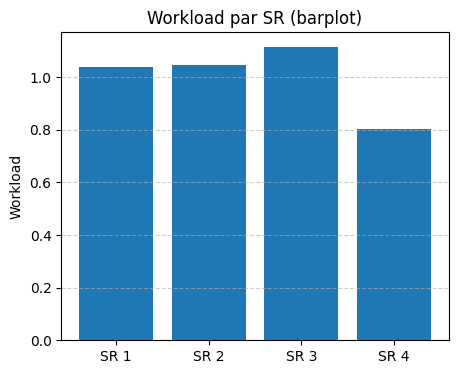

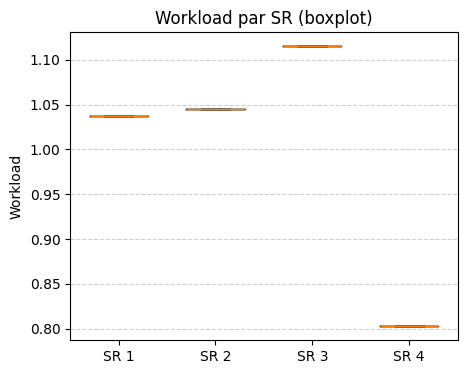


=== 4x22 – Scenario L=0.85, U=1.15 ===
  Best distance  : 160.3200
  Disruption     : 1.1058
Distance totale  : 160.3200
Disruption total : 1.1058

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12, 19]
  Workload = 0.9379

SR 2:
  Bricks   = [11, 13, 14, 18]
  Workload = 1.0447

SR 3:
  Bricks   = [10, 15, 16, 17]
  Workload = 1.1149

SR 4:
  Bricks   = [1, 2, 3, 20, 21, 22]
  Workload = 0.9025



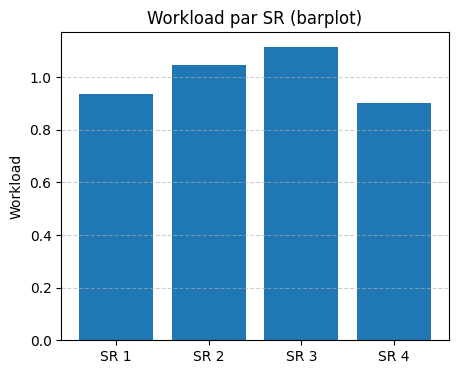

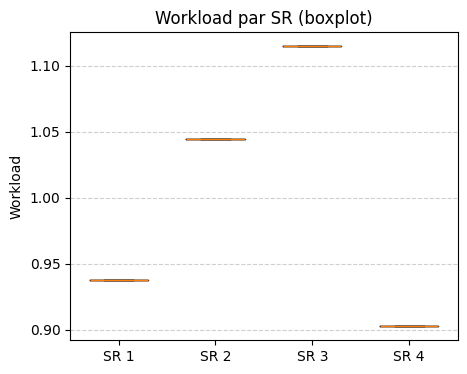


=== 4x22 – Scenario L=0.90, U=1.10 ===
  Best distance  : 162.4300
  Disruption     : 1.1341
Distance totale  : 162.4300
Disruption total : 1.1341

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12, 19]
  Workload = 0.9379

SR 2:
  Bricks   = [11, 13, 14, 17]
  Workload = 1.0730

SR 3:
  Bricks   = [10, 15, 16, 18]
  Workload = 1.0866

SR 4:
  Bricks   = [1, 2, 3, 20, 21, 22]
  Workload = 0.9025



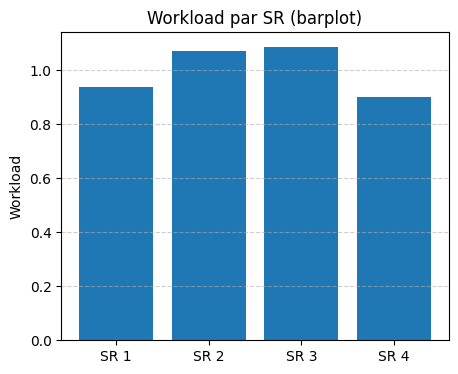

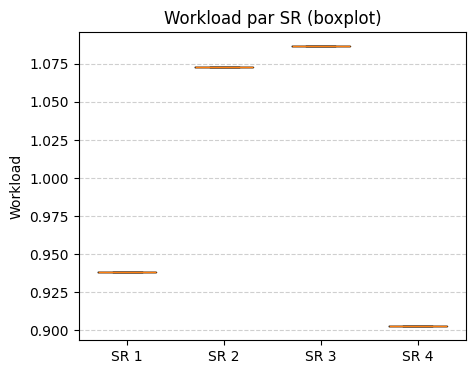

In [40]:
# Dictionnaire pour stocker les meilleures solutions du 4x22
best_small_solutions = {}

for scenario, frontier in frontiers.items():  # scenario = (L, U)
    if not frontier:
        continue
    best_sol = min(frontier, key=lambda s: s["distance"])
    best_small_solutions[scenario] = best_sol

    print(f"\n=== 4x22 – Scenario L={scenario[0]:.2f}, U={scenario[1]:.2f} ===")
    print(f"  Best distance  : {best_sol['distance']:.4f}")
    print(f"  Disruption     : {best_sol['disruption']:.4f}")

    summarize_solution(best_sol, W, SRs_FIXED)

Across the three workload histograms, the distribution remains relatively balanced, with SR2 and SR3 consistently carrying slightly more workload and SR4 remaining below the group average. This pattern reflects a typical outcome of spatial optimization: centrally located SRs (SR2 and SR3) naturally attract more bricks due to proximity, while peripheral SRs (SR1 and SR4) receive fewer assignments. Notably, the differences between the three scenarios are minor, indicating that even when the objective shifts (e.g., distance-optimal vs compromise), the model preserves workload equity within the allowed interval. Overall, the allocation is stable and respects the balance constraints, confirming that improvements in distance do not come at the cost of excessive workload concentration.


=== 100x10 – Scenario L=0.80, U=1.20 ===
  Best distance  : 15.0374
  Disruption     : 2.7746
Distance totale  : 15.0374
Disruption total : 2.7746

SR 1:
  Bricks   = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 21]
  Workload = 1.0784

SR 2:
  Bricks   = [6, 7, 8, 9, 16, 17, 18, 26, 27, 28, 36]
  Workload = 1.1744

SR 3:
  Bricks   = [10, 19, 20, 29, 30, 38, 39, 40]
  Workload = 0.8129

SR 4:
  Bricks   = [22, 23, 24, 25, 31, 32, 33, 34, 41, 42, 43, 52]
  Workload = 1.1937

SR 5:
  Bricks   = [37, 48, 49, 50, 58, 59, 60, 68, 70]
  Workload = 0.9562

SR 6:
  Bricks   = [51, 61, 71, 72, 81, 82, 83, 91, 92, 93, 94]
  Workload = 0.8191

SR 7:
  Bricks   = [53, 62, 63, 64, 73, 74, 75, 84, 85, 95]
  Workload = 0.9801

SR 8:
  Bricks   = [35, 44, 45, 46, 47, 54, 55, 56, 57, 65, 66, 67, 76]
  Workload = 1.1114

SR 9:
  Bricks   = [69, 78, 79, 80, 89, 90]
  Workload = 1.0164

SR 10:
  Bricks   = [77, 86, 87, 88, 96, 97, 98, 99, 100]
  Workload = 0.8573



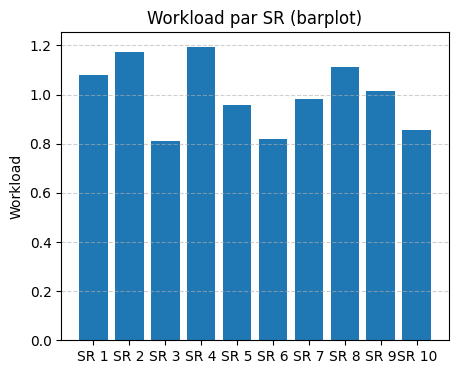

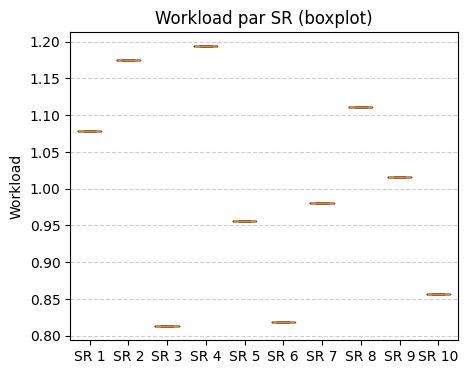

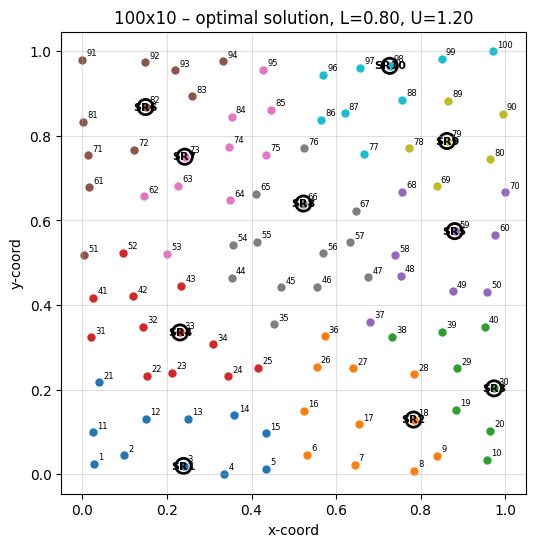


=== 100x10 – Scenario L=0.85, U=1.15 ===
  Best distance  : 15.1760
  Disruption     : 2.7188
Distance totale  : 15.1760
Disruption total : 2.7188

SR 1:
  Bricks   = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 21]
  Workload = 1.0784

SR 2:
  Bricks   = [6, 7, 8, 9, 16, 17, 18, 19, 26, 27, 36]
  Workload = 1.1257

SR 3:
  Bricks   = [10, 20, 28, 29, 30, 38, 39, 40]
  Workload = 0.8616

SR 4:
  Bricks   = [22, 23, 24, 25, 31, 32, 33, 34, 41, 42, 43]
  Workload = 1.1475

SR 5:
  Bricks   = [37, 48, 49, 50, 58, 59, 60, 68, 70]
  Workload = 0.9562

SR 6:
  Bricks   = [51, 61, 71, 72, 81, 82, 83, 91, 92, 93, 94, 95]
  Workload = 0.8889

SR 7:
  Bricks   = [52, 53, 62, 63, 64, 73, 74, 75, 84, 85]
  Workload = 0.9566

SR 8:
  Bricks   = [35, 44, 45, 46, 47, 54, 55, 56, 57, 65, 66, 67, 76]
  Workload = 1.1114

SR 9:
  Bricks   = [69, 78, 79, 80, 89, 90]
  Workload = 1.0164

SR 10:
  Bricks   = [77, 86, 87, 88, 96, 97, 98, 99, 100]
  Workload = 0.8573



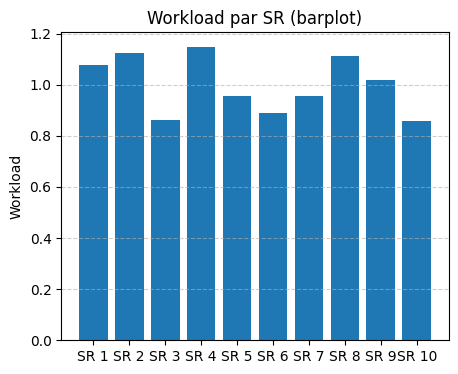

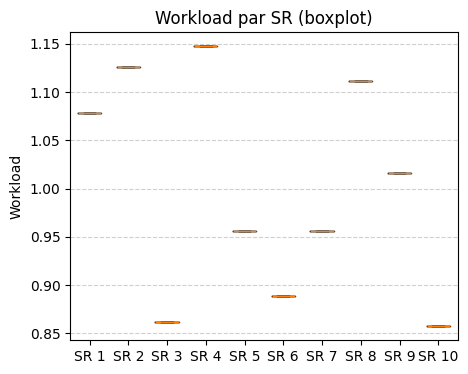

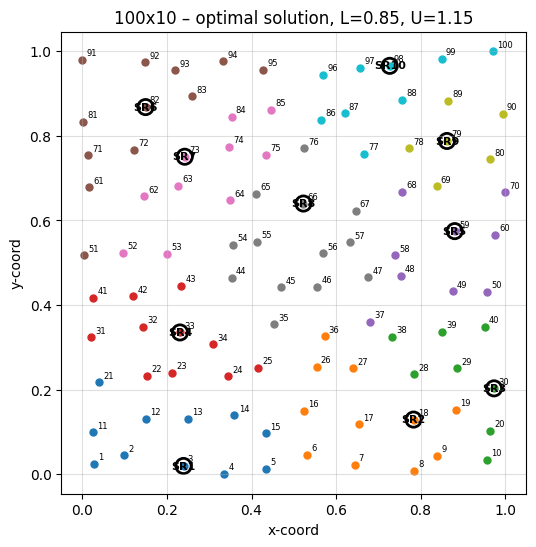


=== 100x10 – Scenario L=0.90, U=1.10 ===
  Best distance  : 15.3797
  Disruption     : 2.9383
Distance totale  : 15.3797
Disruption total : 2.9383

SR 1:
  Bricks   = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 21]
  Workload = 1.0784

SR 2:
  Bricks   = [6, 7, 8, 9, 16, 17, 18, 26, 27, 36]
  Workload = 1.0873

SR 3:
  Bricks   = [10, 19, 20, 28, 29, 30, 38, 39, 40]
  Workload = 0.9000

SR 4:
  Bricks   = [22, 23, 24, 25, 31, 32, 33, 34, 42, 43, 53]
  Workload = 1.0926

SR 5:
  Bricks   = [37, 47, 48, 49, 50, 58, 59, 60, 68, 70]
  Workload = 0.9836

SR 6:
  Bricks   = [51, 61, 71, 72, 81, 82, 83, 85, 91, 92, 93, 94]
  Workload = 0.9119

SR 7:
  Bricks   = [41, 52, 62, 63, 64, 73, 74, 75, 84]
  Workload = 0.9186

SR 8:
  Bricks   = [35, 44, 45, 46, 54, 55, 56, 57, 65, 66, 67, 76]
  Workload = 1.0841

SR 9:
  Bricks   = [69, 78, 79, 80, 89, 90]
  Workload = 1.0164

SR 10:
  Bricks   = [77, 86, 87, 88, 95, 96, 97, 98, 99, 100]
  Workload = 0.9271



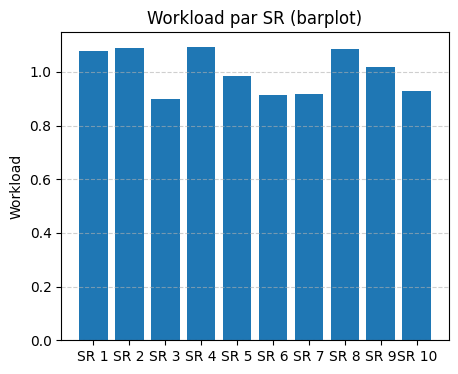

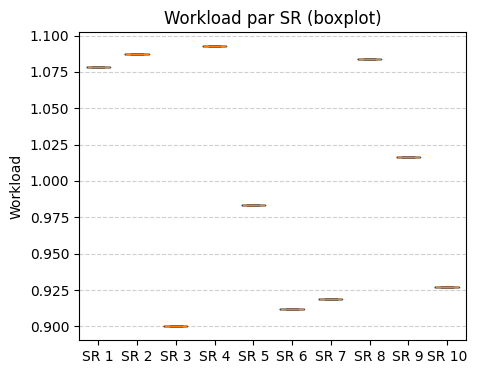

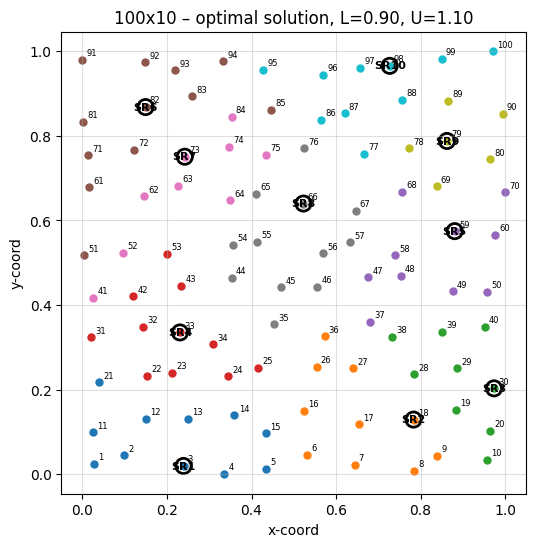

In [41]:
# Dictionnaire pour stocker les meilleures solutions du 100x10
best_large_solutions = {}

for scenario, frontier in frontiers_large.items():  # scenario = (L_large, U_large)
    if not frontier:
        continue
    best_sol = min(frontier, key=lambda s: s["distance"])
    best_large_solutions[scenario] = best_sol

    print(f"\n=== 100x10 – Scenario L={scenario[0]:.2f}, U={scenario[1]:.2f} ===")
    print(f"  Best distance  : {best_sol['distance']:.4f}")
    print(f"  Disruption     : {best_sol['disruption']:.4f}")

    # Optionnel : résumé numérique
    summarize_solution(best_sol, LARGE_W, LARGE_SRs)

    # Optionnel : visualisation dans le plan
    plot_large_solution(best_sol, coords_large, office_coords_large,
                        title=f"100x10 – optimal solution, L={scenario[0]:.2f}, U={scenario[1]:.2f}")


Across the three workload configurations, the effect of tightening the bounds is clearly visible both in the barplots and in the spatial allocations. With the loose interval [0.80,1.20], some SRs (notably SR2, SR3, SR8) operate close to the upper bound, while others (such as SR5, SR10) remain slightly below average. This reflects the model’s ability to assign more bricks to geographically central or dense offices to minimize travel distance. When the range tightens to [0.85,1.15], the spread between representatives decreases: extreme allocations are prevented and the workload distribution becomes more homogeneous, with most SRs converging around the mean. Under the strictest bounds [0.90,1.10], the distribution becomes even more compressed, forcing the system to redistribute bricks away from spatially advantageous centers to respect fairness constraints. While this produces more balanced territories, it also constrains spatial optimization and reduces the model’s capacity to form compact clusters around each SR.

In [44]:
# ------------------------------------------------------------------
# STEP 2.2 – Partial assignment of bricks (LP relaxation)
# ------------------------------------------------------------------

def build_partial_assignment_model(W, D, SR_set, L, U, objective_type,
                                   epsilon=None,
                                   epsilon_trick=EPSILON_TRICK,
                                   initial_assignments=None):
    """
    Same structure as the fixed-center model, but x is continuous in [0,1].
    """
    model = pyo.ConcreteModel()
    bricks = sorted(W.keys())
    model.I = pyo.Set(initialize=bricks)
    model.J = pyo.Set(initialize=SR_set)

    # x_ij is the fraction of brick i assigned to SR j
    model.x = pyo.Var(model.I, model.J, bounds=(0, 1), within=pyo.NonNegativeReals)

    if initial_assignments is None:
        initial_assignments = INITIAL_ASSIGNMENTS

    Z_Dist = sum(D[i][j] * model.x[i, j] for i in model.I for j in model.J)
    Z_Disc = sum(
        W[i] * model.x[i, j]
        for j in model.J
        for i in model.I
        if (j in initial_assignments) and (i not in initial_assignments[j])
    )

    if objective_type == "distance":
        model.obj = pyo.Objective(expr=Z_Dist, sense=pyo.minimize)
    elif objective_type == "disruption":
        model.obj = pyo.Objective(expr=Z_Disc, sense=pyo.minimize)
    elif objective_type == "epsilon":
        if epsilon is None:
            raise ValueError("epsilon must be provided when objective_type='epsilon'.")
        model.obj = pyo.Objective(expr=Z_Dist + epsilon_trick * Z_Disc, sense=pyo.minimize)
        model.epsilon_con = pyo.Constraint(expr=Z_Disc <= epsilon)
    else:
        raise ValueError("Invalid objective_type for partial assignment.")

    # Sum_j x_ij = 1 for each brick
    def assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.J) == 1
    model.assignment_con = pyo.Constraint(model.I, rule=assignment_rule)

    # Workload balance
    def workload_lower_rule(model, j):
        return sum(W[i] * model.x[i, j] for i in model.I) >= L
    model.workload_low_con = pyo.Constraint(model.J, rule=workload_lower_rule)

    def workload_upper_rule(model, j):
        return sum(W[i] * model.x[i, j] for i in model.I) <= U
    model.workload_up_con = pyo.Constraint(model.J, rule=workload_upper_rule)

    return model, Z_Dist, Z_Disc


--- STEP 2.2: Partial assignment (LP relaxation) for all scenarios ---

[LP] Solving partial assignment for scenario [0.80, 1.20]
Optimized distance = 148.6289
Disruption at optimized distance = 1.6200
Workload balance [0.80, 1.20] – disruption range: [0.1377, 1.6200]
Efficient (Distance, Disruption) solutions with partial assignment:
  Dist = 148.6289, Disc = 1.6200
  Dist = 148.6399, Disc = 1.5897
  Dist = 148.6509, Disc = 1.5595
  Dist = 148.6666, Disc = 1.5292
  Dist = 148.6869, Disc = 1.4990
  Dist = 148.7073, Disc = 1.4687
  Dist = 148.7276, Disc = 1.4385
  Dist = 148.7479, Disc = 1.4082
  Dist = 148.7683, Disc = 1.3780
  Dist = 148.7886, Disc = 1.3477
  Dist = 148.8089, Disc = 1.3175
  Dist = 148.8370, Disc = 1.2872
  Dist = 148.8956, Disc = 1.2570
  Dist = 148.9541, Disc = 1.2267
  Dist = 149.0126, Disc = 1.1965
  Dist = 149.0711, Disc = 1.1662
  Dist = 149.1430, Disc = 1.1360
  Dist = 149.3311, Disc = 1.1057
  Dist = 149.6175, Disc = 1.0755
  Dist = 149.9625, Disc = 1.0452
  

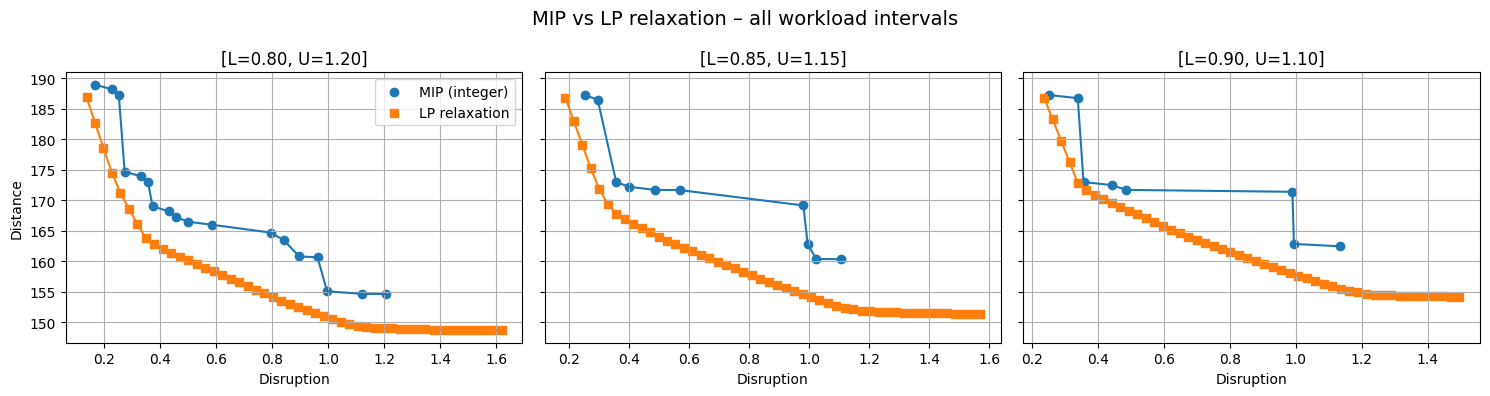

In [45]:
scenarios = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

partial_frontiers = {}

print("\n--- STEP 2.2: Partial assignment (LP relaxation) for all scenarios ---")

# 1) Calculer les frontières LP pour chaque scénario
for (L, U) in scenarios:
    print(f"\n[LP] Solving partial assignment for scenario [{L:.2f}, {U:.2f}]")
    partial_results = find_efficient_frontier(
        W, D, SRs_FIXED,
        L=L, U=U,
        builder_func=build_partial_assignment_model
    )
    partial_frontiers[(L, U)] = partial_results

    print("Efficient (Distance, Disruption) solutions with partial assignment:")
    for sol in partial_results:
        print(f"  Dist = {sol['distance']:.4f}, Disc = {sol['disruption']:.4f}")

# 2) Plots MIP vs LP pour chaque scénario, côte à côte
fig, axes = plt.subplots(1, len(scenarios), figsize=(15, 4), sharey=True)

for ax, (L, U) in zip(axes, scenarios):
    # --- MIP frontier ---
    mip_frontier = frontiers[(L, U)]
    mip_sorted = sorted(mip_frontier, key=lambda s: s["disruption"])
    xs_mip = [s["disruption"] for s in mip_sorted]
    ys_mip = [s["distance"]   for s in mip_sorted]
    ax.scatter(xs_mip, ys_mip, marker="o", label="MIP (integer)")
    ax.plot(xs_mip, ys_mip)

    # --- LP frontier ---
    lp_frontier = partial_frontiers[(L, U)]
    lp_sorted = sorted(lp_frontier, key=lambda s: s["disruption"])
    xs_lp = [s["disruption"] for s in lp_sorted]
    ys_lp = [s["distance"]   for s in lp_sorted]
    ax.scatter(xs_lp, ys_lp, marker="s", label="LP relaxation")
    ax.plot(xs_lp, ys_lp)

    ax.set_xlabel("Disruption")
    ax.set_title(f"[L={L:.2f}, U={U:.2f}]")
    ax.grid(True)

axes[0].set_ylabel("Distance")
axes[0].legend()
fig.suptitle("MIP vs LP relaxation – all workload intervals", fontsize=14)
plt.tight_layout()
plt.show()


Across all three workload intervals, the LP relaxation consistently produces a lower distance–disruption frontier than the integer model, which is expected since fractional assignments enlarge the feasible space. The gap is particularly visible in the low-disruption region: when workload balance is still preserved and reassignments are limited, the MIP solution remains constrained by integrality and cannot exploit small, fractional adjustments to reduce travel distance. As disruption increases, the two curves converge, indicating that once the model is free to reorganize territories extensively, the structural advantage of fractional allocation diminishes. Notably, tightening the workload interval [0.80,1.20] → [0.85,1.15] → [0.90,1.10] compresses the integer frontier sharply, while the LP frontier remains relatively smooth. This demonstrates that fairness constraints impact combinatorial feasibility much more than continuous feasibility, reinforcing that the integrality gap is primarily driven by spatial indivisibility of bricks rather than the geometry of the objective landscape.

In [49]:
# ------------------------------------------------------------------
# STEP 2.3 & STEP 3 – 22x22 brick-to-brick distance matrix (from Excel)
# ------------------------------------------------------------------

import pandas as pd

# Charger le fichier de distances brick–brick
xl_dist = pd.ExcelFile("Pfizer_Project\data\distances.xlsx")  # adapte le chemin si besoin
df_bb = xl_dist.parse("brick-brick")

# Les lignes 1..22 contiennent les distances, la colonne 1 les indices de briques,
# la ligne 0 (colonnes 2..) contient les indices de briques en colonnes.
row_ids = df_bb.iloc[1:, 1].astype(int).tolist()     # 1,2,...,22
col_ids = df_bb.iloc[0, 2:].astype(int).tolist()     # 1,2,...,22
vals = df_bb.iloc[1:, 2:].to_numpy()                 # matrice 22x22

D_full = {}
for r, i in enumerate(row_ids):
    for c, j in enumerate(col_ids):
        D_full[(i, j)] = float(vals[r, c])

def get_distance_i_to_k(i, k):
    """Distance entre brick i et brick k (22x22 réel)."""
    return D_full[(i, k)]

In [ ]:
# ------------------------------------------------------------------
# STEP 2.3 – Locating a new SR office (+25% demand) for ALL SCENARIOS
# ------------------------------------------------------------------

results_23 = {}  

print("\n=== STEP 2.3 : Best location for 5th SR for all workload intervals ===")

for (L_rel, U_rel) in scenarios:

    print(f"\n--- Scenario [{L_rel:.2f}, {U_rel:.2f}] ---")

    # Nouveaux workloads (+25%)
    N_new = 5
    SRs_new = list(range(1, N_new + 1))
    W_new = {i: 1.25 * W[i] for i in BRICKS}

    # Recalcul de la moyenne & des bornes
    TOTAL_WORKLOAD_NEW = sum(W_new.values())
    avg_workload_new = TOTAL_WORKLOAD_NEW / N_new

    L_new = L_rel * avg_workload_new
    U_new = U_rel * avg_workload_new

    print(f"  Total new workload = {TOTAL_WORKLOAD_NEW:.4f}")
    print(f"  Avg workload/SR    = {avg_workload_new:.4f}")
    print(f"  L_new={L_new:.4f}, U_new={U_new:.4f}")

    # Recherche du meilleur centre (parmis les 22 briques)
    best_total_distance = float("inf")
    best_center = None
    best_assignment = None

    for k in BRICKS:  # chaque brique candidate devient centre du SR5
        # Construire D_k (distance vers SR1..4 + SR5 placé en k)
        D_k = {i: dict(D[i]) for i in BRICKS}
        for i in BRICKS:
            D_k[i][N_new] = get_distance_i_to_k(i, k)

        # Résoudre avec centres fixes
        model_k, Z_Dist_k, _ = build_fixed_center_model(
            W=W_new,
            D=D_k,
            SR_set=SRs_new,
            L=L_new,
            U=U_new,
            objective_type="distance",
            initial_assignments={**INITIAL_ASSIGNMENTS, 5: set()}
        )

        res = solver.solve(model_k, tee=False)
        if (res.solver.status == pyo.SolverStatus.ok and
                res.solver.termination_condition == pyo.TerminationCondition.optimal):
            total_dist_k = float(pyo.value(Z_Dist_k))

            if total_dist_k < best_total_distance - 1e-6:
                best_total_distance = total_dist_k
                best_center = k

                # Enregistrer l'affectation
                assignment_k = {}
                for i in model_k.I:
                    for j in model_k.J:
                        if pyo.value(model_k.x[i, j]) > 0.5:
                            assignment_k[i] = j
                            break
                best_assignment = assignment_k

    # Stocker les résultats
    results_23[(L_rel, U_rel)] = {
        "best_center": best_center,
        "best_distance": best_total_distance,
        "assignment": best_assignment,
        "L_new": L_new,
        "U_new": U_new
    }

    print(f"  Best center brick = {best_center}")
    print(f"  Total distance     = {best_total_distance:.4f} km")



=== STEP 2.3 : Best location for 5th SR for all workload intervals ===

--- Scenario [0.80, 1.20] ---
  Total new workload = 5.0000
  Avg workload/SR    = 1.0000
  L_new=0.8000, U_new=1.2000
  Best center brick = 2
  Total distance     = 133.1768 km

--- Scenario [0.85, 1.15] ---
  Total new workload = 5.0000
  Avg workload/SR    = 1.0000
  L_new=0.8500, U_new=1.1500
  Best center brick = 19
  Total distance     = 134.8242 km

--- Scenario [0.90, 1.10] ---
  Total new workload = 5.0000
  Avg workload/SR    = 1.0000
  L_new=0.9000, U_new=1.1000
  Best center brick = 19
  Total distance     = 139.5642 km



Scenario (0.8, 1.2)
Distance totale  : 133.1768
Disruption total : 0.0000

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 12]
  Workload = 1.0420

SR 2:
  Bricks   = [13, 14, 18]
  Workload = 1.1974

SR 3:
  Bricks   = [10, 11, 16, 17]
  Workload = 0.9878

SR 4:
  Bricks   = [15, 22]
  Workload = 0.8307

SR 5:
  Bricks   = [1, 2, 3, 19, 20, 21]
  Workload = 0.9421



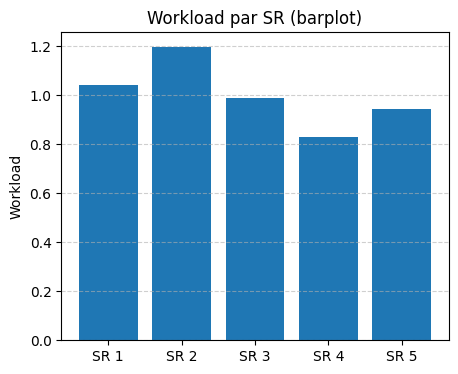

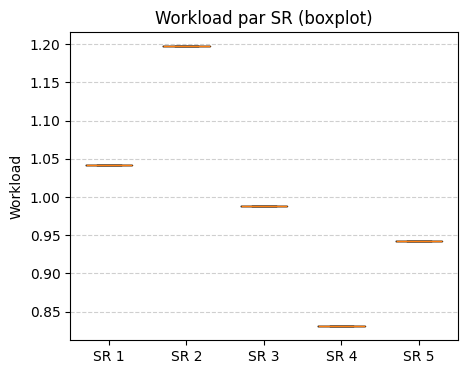


Scenario (0.85, 1.15)
Distance totale  : 134.8242
Disruption total : 0.0000

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9]
  Workload = 0.9385

SR 2:
  Bricks   = [13, 14]
  Workload = 1.1440

SR 3:
  Bricks   = [10, 11, 16, 17, 18]
  Workload = 1.0411

SR 4:
  Bricks   = [3, 15, 22]
  Workload = 0.9590

SR 5:
  Bricks   = [1, 2, 12, 19, 20, 21]
  Workload = 0.9174



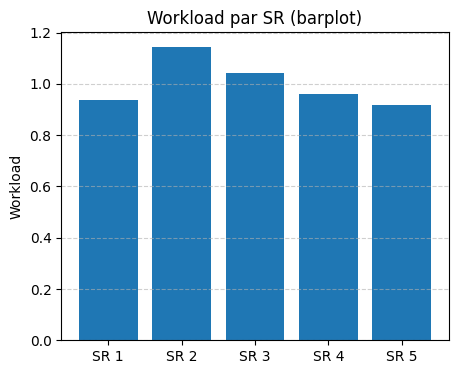

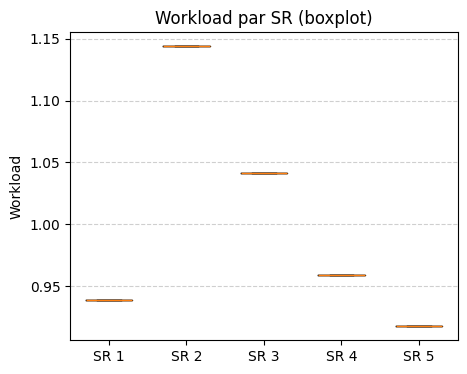


Scenario (0.9, 1.1)
Distance totale  : 139.5642
Disruption total : 0.0000

SR 1:
  Bricks   = [4, 5, 6, 7, 8, 9, 13]
  Workload = 1.0604

SR 2:
  Bricks   = [14, 18]
  Workload = 1.0755

SR 3:
  Bricks   = [10, 11, 16, 17]
  Workload = 0.9878

SR 4:
  Bricks   = [3, 15, 22]
  Workload = 0.9590

SR 5:
  Bricks   = [1, 2, 12, 19, 20, 21]
  Workload = 0.9174



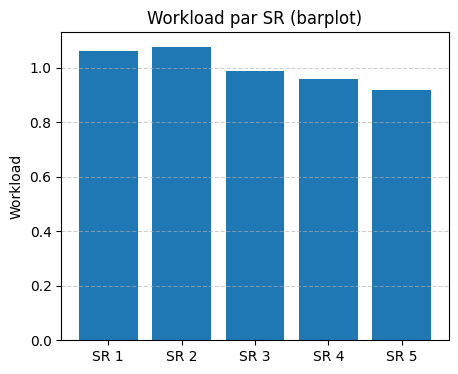

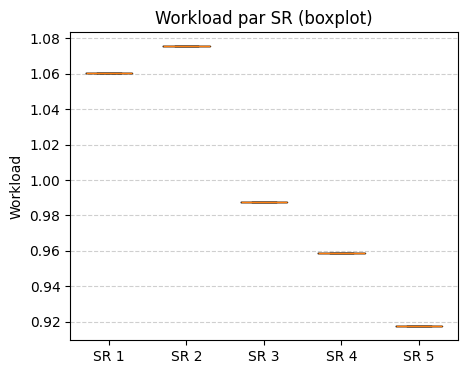

In [55]:
for scenario, sol in results_23.items():
    print("\nScenario", scenario)
    summarize_solution(
        {"distance": sol["best_distance"],
         "disruption": 0.0,
         "assignment": sol["assignment"]},
        W_new,
        SRs_new
    )

When a fifth SR is introduced with a 25% increase in demand, the workload barplots and optimization results show how the preferred office location depends strongly on the balance constraints. Under the loose interval [0.80,1.20], the model chooses brick 2 as the new center and achieves the lowest total distance (133.18 km), at the price of a relatively uneven workload distribution where SR2 and SR3 operate close to the upper bound while SR4 and SR5 remain lighter. As the interval tightens to [0.85,1.15] and then [0.90,1.10], the best location switches to brick 19, a more central position that facilitates sharing bricks more evenly across SRs; the workload bars become noticeably flatter, but the total distance increases to 134.82 km and 139.56 km respectively. This confirms that stricter fairness requirements push the new office towards a “compromise” location that equalizes load at the expense of additional travel.

## Step 3 — SR Office Relocation and Joint Facility–Allocation Optimization

Step 3 generalizes the territory optimization problem by allowing the Sales Representatives’ offices to relocate instead of remaining fixed. In this setting, the model simultaneously determines the optimal location of each SR office and the assignment of bricks to those offices. This transforms the formulation from a pure allocation problem into a **facility–location model**, where decisions about spatial infrastructure and customer coverage are interdependent. The objective is not only to minimize travel distance or balance workload, but also to control the extent of disruption generated by changing the physical franchise structure itself.

Introducing relocation fundamentally alters the nature of the optimization landscape. While fixed centers constrain the model to adapt territories around pre-existing office locations, relocation enables the system to reshape territories more freely, forming compact clusters around strategically selected positions. However, relocation is also highly disruptive and costly in real-world contexts: it involves moving representatives, modifying client relationships, and adjusting internal logistics. To capture this trade-off, Step 3 incorporates an additional metric, the number of relocated offices relative to the initial configuration, which acts as a structural cost that competes with spatial efficiency.

By jointly optimizing distance, workload equity, and relocation penalties, Step 3 seeks operationally realistic solutions that balance **territorial compactness**, **organizational stability**, and **investment constraints**. This final stage bridges optimization with managerial decision-making: whereas Step 1 and Step 2 explore what can be achieved under fixed infrastructure, Step 3 explores how adjusting the infrastructure itself can unlock new performance regimes, and under what conditions such adjustments are justified.

In [56]:
# ------------------------------------------------------------------
# STEP 3 – Variable center bricks (office location optimization)
# ------------------------------------------------------------------

def build_variable_center_model(W, D_full, N_offices, objective_type,
                                max_reloc=None,
                                epsilon_wm=None,
                                epsilon_trick=EPSILON_TRICK):
    """
    Facility-location-style model:
      - x[i,j] = 1 if brick i is served by office at brick j
      - y[j]   = 1 if an office is opened at brick j
      - wm     = maximum workload over all offices

    Objectives:
      - 'distance_fair': minimize distance + epsilon_trick * wm
      - 'fairness_only': minimize wm

    The number of offices is fixed to N_offices.
    """
    model = pyo.ConcreteModel()
    bricks = sorted(W.keys())
    model.I = pyo.Set(initialize=bricks)   # customer bricks
    model.J = pyo.Set(initialize=bricks)   # potential office locations

    # Decision variables
    model.x = pyo.Var(model.I, model.J, within=pyo.Binary)
    model.y = pyo.Var(model.J, within=pyo.Binary)
    model.wm = pyo.Var(within=pyo.NonNegativeReals)

    # Objective terms
    Z_Dist = sum(D_full[(i, j)] * model.x[i, j] for i in model.I for j in model.J)
    Z_Fair = model.wm
    Z_retained = sum(model.y[j] for j in INITIAL_OFFICES_INDICES)
    Z_reloc = N_offices - Z_retained  # number of relocated offices

    if objective_type == "distance_fair":
        model.obj = pyo.Objective(expr=Z_Dist + epsilon_trick * Z_Fair, sense=pyo.minimize)
    elif objective_type == "fairness_only":
        model.obj = pyo.Objective(expr=Z_Fair, sense=pyo.minimize)
    else:
        raise ValueError("Invalid objective_type for variable-center model.")

    # Constraints
    # 1. Each brick assigned to exactly one office
    def assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.J) == 1
    model.assignment_con = pyo.Constraint(model.I, rule=assignment_rule)

    # 2. Exactly N_offices offices are opened
    model.num_offices_con = pyo.Constraint(expr=sum(model.y[j] for j in model.J) == N_offices)

    # 3. Assignment only to open offices
    def link_office_assignment_rule(model, i, j):
        return model.x[i, j] <= model.y[j]
    model.link_con = pyo.Constraint(model.I, model.J, rule=link_office_assignment_rule)

    # 4. Definition of wm (max workload over all offices)
    def minmax_workload_rule(model, j):
        return model.wm >= sum(W[i] * model.x[i, j] for i in model.I)
    model.minmax_con = pyo.Constraint(model.J, rule=minmax_workload_rule)

    # 5. Upper bound on number of relocated offices (optional)
    if max_reloc is not None:
        model.reloc_con = pyo.Constraint(expr=Z_reloc <= max_reloc)

    # 6. Epsilon-constraint on fairness (optional)
    if epsilon_wm is not None:
        model.epsilon_wm_con = pyo.Constraint(expr=Z_Fair <= epsilon_wm)

    return model, Z_Dist, Z_Fair, Z_reloc


def find_three_objective_frontier(W, D_full, N_offices):
    """
    Compute a set of efficient solutions for the 3-objective problem:
      (total distance, max workload, # relocated offices).

    We sweep:
      - the allowed number of relocated offices k_reloc = 0..N_offices (Z_reloc <= k_reloc)
      - an epsilon constraint on max workload (wm).
    """
    # (1) Minimize fairness alone to get wm_min
    model_fair_min, _, Z_Fair_expr, _ = build_variable_center_model(
        W, D_full, N_offices, "fairness_only"
    )
    res = solver.solve(model_fair_min, tee=False)
    if (res.solver.status != pyo.SolverStatus.ok or
            res.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise RuntimeError("Fairness-only model did not solve optimally.")
    wm_min = float(pyo.value(Z_Fair_expr))

    wm_max = 1.2  # consistent with workload upper bound used in Step 1
    wm_step = 0.01
    epsilon_wm_values = np.arange(wm_min, wm_max + wm_step / 2.0, wm_step)

    print(f"Min-max workload wm in [{wm_min:.4f}, {wm_max:.2f}]")

    all_solutions = []

    # (2) Sweep over allowed # of relocated offices
    for k_reloc in range(N_offices + 1):
        best_dist_for_k = float("inf")

        print(f"\n--- max relocated offices = {k_reloc} ---")

        for eps_wm in epsilon_wm_values:
            model, Z_Dist_expr, Z_Fair_expr, Z_reloc_expr = build_variable_center_model(
                W, D_full, N_offices,
                objective_type="distance_fair",
                max_reloc=k_reloc,
                epsilon_wm=eps_wm
            )
            res = solver.solve(model, tee=False)
            if (res.solver.status == pyo.SolverStatus.ok and
                    res.solver.termination_condition == pyo.TerminationCondition.optimal):
                dist_val = float(pyo.value(Z_Dist_expr))
                fair_val = float(pyo.value(Z_Fair_expr))
                reloc_val = float(pyo.value(Z_reloc_expr))

                if dist_val < best_dist_for_k - 1e-6:
                    best_dist_for_k = dist_val
                    all_solutions.append({
                        "distance": dist_val,
                        "wm": fair_val,
                        "relocated": reloc_val
                    })

    # Remove duplicates and sort (par distance puis wm puis reloc)
    unique = {(round(s["distance"], 6), round(s["wm"], 6), round(s["relocated"], 6)): s
              for s in all_solutions}
    all_solutions = [unique[k] for k in sorted(unique.keys())]
    return all_solutions

In [57]:
# --- STEP 3: Run the 3-objective analysis (distance, fairness, #relocated offices) ---

RUN_STEP3 = True  # Set False if you want to skip this part

if RUN_STEP3:
    three_obj_results = find_three_objective_frontier(W, D_full, N)
    print("\nEfficient solutions (Distance, Max Workload, #Relocated offices):")
    for sol in three_obj_results:
        print(f"  Dist = {sol['distance']:.4f}, wm = {sol['wm']:.4f}, reloc = {sol['relocated']:.2f}")
else:
    print("Skipping Step 3 (set RUN_STEP3 = True to compute the three-objective frontier).")

Min-max workload wm in [1.0001, 1.20]

--- max relocated offices = 0 ---

--- max relocated offices = 1 ---

--- max relocated offices = 2 ---

--- max relocated offices = 3 ---

--- max relocated offices = 4 ---

Efficient solutions (Distance, Max Workload, #Relocated offices):
  Dist = 103.5640, wm = 1.1307, reloc = 4.00
  Dist = 103.5640, wm = 1.1307, reloc = 4.00
  Dist = 103.6267, wm = 1.1307, reloc = 3.00
  Dist = 105.0565, wm = 1.1149, reloc = 2.00
  Dist = 106.5979, wm = 1.0866, reloc = 3.00
  Dist = 106.7132, wm = 1.1149, reloc = 1.00
  Dist = 107.1486, wm = 1.0866, reloc = 2.00
  Dist = 108.8053, wm = 1.0866, reloc = 1.00
  Dist = 109.3325, wm = 1.0439, reloc = 4.00
  Dist = 109.9732, wm = 1.0439, reloc = 3.00
  Dist = 110.1309, wm = 1.0706, reloc = 2.00
  Dist = 110.9712, wm = 1.0068, reloc = 3.00
  Dist = 111.0751, wm = 1.0439, reloc = 2.00
  Dist = 111.7906, wm = 1.0068, reloc = 2.00
  Dist = 112.6248, wm = 1.0706, reloc = 1.00
  Dist = 112.9162, wm = 1.0447, reloc = 1.00


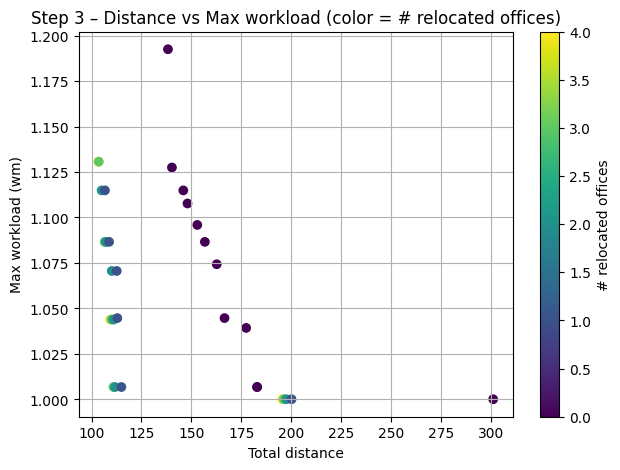

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_three_obj_scatter(results):
    """
    results : liste de dicts avec clés 'distance', 'wm', 'relocated'
    """
    if not results:
        print("No results to plot.")
        return

    dist = np.array([s["distance"] for s in results])
    wm   = np.array([s["wm"]       for s in results])
    reloc = np.array([s["relocated"] for s in results])

    plt.figure(figsize=(7,5))
    sc = plt.scatter(dist, wm, c=reloc)
    plt.xlabel("Total distance")
    plt.ylabel("Max workload (wm)")
    plt.title("Step 3 – Distance vs Max workload (color = # relocated offices)")
    plt.grid(True)
    cbar = plt.colorbar(sc)
    cbar.set_label("# relocated offices")
    plt.show()

plot_three_obj_scatter(three_obj_results)

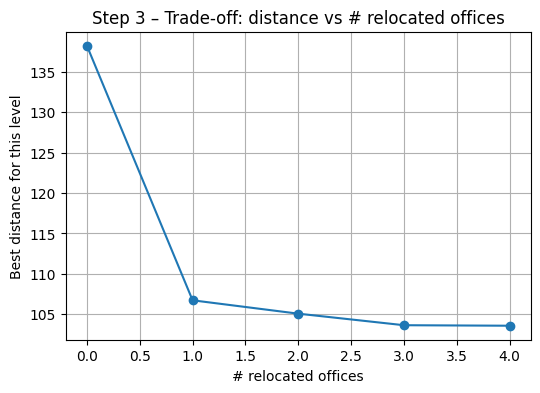

In [61]:
def plot_distance_vs_relocated(results):
    # on agrège par niveau de reloc : min distance pour chaque nb de reloc
    by_reloc = {}
    for s in results:
        k = round(s["relocated"])
        if k not in by_reloc or s["distance"] < by_reloc[k]:
            by_reloc[k] = s["distance"]

    ks = sorted(by_reloc.keys())
    dist_min = [by_reloc[k] for k in ks]

    plt.figure(figsize=(6,4))
    plt.plot(ks, dist_min, marker="o")
    plt.xlabel("# relocated offices")
    plt.ylabel("Best distance for this level")
    plt.title("Step 3 – Trade-off: distance vs # relocated offices")
    plt.grid(True)
    plt.show()

plot_distance_vs_relocated(three_obj_results)

The relocation analysis reveals a clear diminishing-returns structure: the first office relocation produces a dramatic improvement in total distance, reducing it from roughly 138 km to about 106 km, while additional relocations offer much smaller marginal gains. This behaviour is also reflected in the Distance–Max workload scatter: most efficient points lie on a downward frontier, where relocation allows territories to be reshaped around new centers and the maximal workload gradually reduced. However, deeper improvements in distance typically require allocating more than one relocation, while efforts to push workload very close to the lower bound (≈1.00) force the solution into highly fragmented spatial configurations with several relocations and much higher total distance. In other words, relocation has strong leverage early on, but its benefit decays rapidly as the network becomes spatially saturated; past a certain point, extra relocations mostly serve to balance workloads rather than meaningfully reduce travel.